In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE


In [2]:
data_pd = pd.read_csv("data_cleaned.csv")
data_pd.head()

,Unnamed: 0,SampleID,Age,Sex,Nationality,Diversity,BMI_group,Actinomycetaceae,Aerococcus,Aeromonas,...,Uncultured Clostridium (sensu stricto)les I,Uncultured Clostridium (sensu stricto)les II,Uncultured Mollicutes,Uncultured Selenomonadaceae,Veillonella,Vibrio,Weissella et rel.,Wissella et rel.,Xanthomonadaceae,Yersinia et rel.
0,0,Sample-1,28.0,male,US,5.76,severeobese,72.018955,36.677499,42.602327,...,1104.414062,1028.468474,521.322821,106.394227,211.821670,154.965223,171.075788,61.107101,77.708572,148.457166
1,1,Sample-2,24.0,female,US,6.06,obese,71.617440,35.093902,38.339812,...,18897.145365,10796.271198,4415.402080,56.550318,200.735634,167.467197,116.656049,55.221793,75.723312,148.153760
2,2,Sample-3,52.0,male,US,5.50,lean,76.788552,36.468459,41.049680,...,9941.426890,2382.601913,2705.456410,35.087364,143.295196,177.587051,137.614018,36.587206,78.451328,151.829451
3,3,Sample-4,22.0,female,US,5.87,underweight,74.153361,35.983472,40.919850,...,1707.346473,2881.873156,575.770921,35.909907,180.882271,205.570562,115.188297,44.524188,82.810934,152.548577
4,4,Sample-5,25.0,female,US,5.89,lean,77.065064,37.466006,42.746629,...,32454.018243,7598.565773,16017.026792,54.862005,223.830484,174.345496,138.353411,63.445514,86.347452,156.447511


In [3]:
# creates a list of dictionaries of the distributions of selected features of a selected samples of the data
def metadata_distributions(dataframe, features = ["Sex", "Nationality", "BMI_group"]):
    feature_dist = []
    for feature in features:
        percentages = {}
        for group in np.unique(dataframe[feature]):
            percentages[group] = len(
                dataframe[dataframe[feature] == group]) / len(dataframe[feature])
        feature_dist.append(percentages)
    return feature_dist


In [4]:
data = np.array(data_pd.values[:,7:])
data = preprocessing.Normalizer().fit_transform(data)

sex = data_pd["Sex"].copy()
sex[np.where(sex == "male")[0]] = 1
sex[np.where(sex == "female")[0]] = 0


Clustering:

In [5]:
# try eps = [0.3,0.31,0.32,0.33,0.5], min_samples = [3,4,5,10,20]. Looks nice with PCA when eps=0.3 and min_samples=20
dbscan_clustering = DBSCAN(eps=0.3, min_samples=20)
kmeans_4_clustering = KMeans(n_clusters=4)
kmeans_8_clustering = KMeans(n_clusters=8)
# dbscan_clustering = OPTICS(eps=0.3,min_samples=10) # can't find any clusters with this
dbscan_labels = dbscan_clustering.fit_predict(data)
kmeans_4_labels = kmeans_4_clustering.fit_predict(data)
kmeans_8_labels = kmeans_8_clustering.fit_predict(data)
print(np.unique(dbscan_labels))
print(np.unique(kmeans_4_labels))
print(np.unique(kmeans_8_labels))

for i in range(-1, len(np.unique(dbscan_labels))):
    print("cluster ", i, " has size: ", len(
        dbscan_labels[dbscan_labels == i]))


[-1  0  1  2  3]
[0 1 2 3]
[0 1 2 3 4 5 6 7]
cluster  -1  has size:  687
cluster  0  has size:  158
cluster  1  has size:  80
cluster  2  has size:  55
cluster  3  has size:  77
cluster  4  has size:  0


Dimensionality Reduction:

(1057, 2)


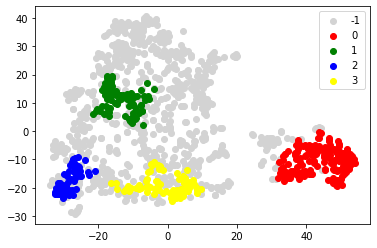

In [7]:
# for samples

# with TSNE I can visually discern e.g. 8 clusters easily, with kernelPCA just 3, maybe 4
pca_model = PCA(n_components=2)
kernel_pca_model = KernelPCA(n_components=2, kernel="rbf", gamma=4)
tsne_model = TSNE(n_components=2, perplexity=30)
# pca_model = KernelPCA(n_components=2, kernel="rbf", gamma=10) # this one is faszinating (choose gamma 4 to 10)

pca_model.fit(data)
kernel_pca_model.fit(data)
tsne_model.fit(data)
pca_projected_data = pca_model.fit_transform(data)
kernel_pca_projected_data = kernel_pca_model.fit_transform(data)
tsne_projected_data = tsne_model.fit_transform(data)


# print(pca_projected_data.shape)

# colors = ["lightgrey","red", "green", "blue", "yellow", "magenta", "lightblue", "black", "brown"]

# for i, l in enumerate(np.unique(dbscan_labels)):
#     cluster_data = projected_data[dbscan_labels==l]
#     plt.scatter(cluster_data[:, 0], cluster_data[:, 1],
#                 c=colors[i], label=l)
# plt.legend()


Export the cluster labels and the projected data as csv:

In [15]:
### CLUSTER LABELS ###


### PROJECTION LABELS ###


### EXPORT ###

data_final = np.concatenate(
    [dbscan_labels[:, np.newaxis], kmeans_4_labels[:, np.newaxis], kmeans_8_labels[:, np.newaxis], 
    pca_projected_data, kernel_pca_projected_data, tsne_projected_data], axis=1)
data_final = pd.DataFrame(data_final, columns=[
                          "dbscan", "kmeans_4", "kmeans_8", "x_pca", "y_pca", "x_kernel_pca", "y_kernel_pca", "x_tsne", "y_tsne"])
# data_final = pd.DataFrame(data_final, columns=["cluster", "x", "y"])
data_final[["dbscan","kmeans_4", "kmeans_8"]] = data_final[["dbscan","kmeans_4", "kmeans_8"]].astype(int)
# data_final["cluster"] = data_final["cluster"].astype(int)
data_final.to_csv("cluster_data.csv",sep=",")
# data_final.head()


In [ ]:
### FOR THE OLD DATASET ###

# data_final = np.concatenate(
#     [dbscan_labels[:, np.newaxis], projected_data], axis=1)
# data_final = pd.DataFrame(data_final, columns=["cluster", "x", "y"])
# data_final["cluster"] = data_final["cluster"].astype(int)
# data_final.to_csv("cluster_data.csv", sep=",")


In [7]:
print(list(metadata_distributions(data_pd)[2].values()))

[0.4607379375591296, 0.020813623462630087, 0.2119205298013245, 0.1901608325449385, 0.0946073793755913, 0.021759697256385997]


Distributions of all data:  [{'female': 0.6111636707663197, 'male': 0.3888363292336802}, {'CentralEurope': 0.5837275307473982, 'EasternEurope': 0.000946073793755913, 'Scandinavia': 0.26017029328287605, 'SouthEurope': 0.08514664143803216, 'UKIE': 0.03784295175023652, 'US': 0.03216650898770104}, {'lean': 0.4607379375591296, 'morbidobese': 0.020813623462630087, 'obese': 0.2119205298013245, 'overweight': 0.1901608325449385, 'severeobese': 0.0946073793755913, 'underweight': 0.021759697256385997}]
Distributions of cluster  0 :  [{'female': 0.61875, 'male': 0.38125}, {'CentralEurope': 0.33125, 'Scandinavia': 0.49375, 'SouthEurope': 0.11875, 'UKIE': 0.04375, 'US': 0.0125}, {'lean': 0.525, 'obese': 0.125, 'overweight': 0.25, 'severeobese': 0.05, 'underweight': 0.05}]


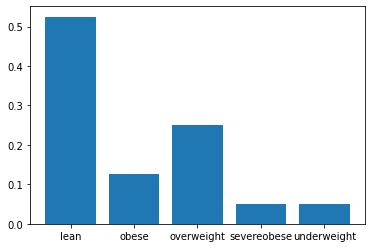

Distributions of cluster  1 :  [{'female': 0.48333333333333334, 'male': 0.5166666666666667}, {'CentralEurope': 0.7388888888888889, 'Scandinavia': 0.16111111111111112, 'SouthEurope': 0.05, 'UKIE': 0.027777777777777776, 'US': 0.022222222222222223}, {'lean': 0.4444444444444444, 'morbidobese': 0.03888888888888889, 'obese': 0.3, 'overweight': 0.08333333333333333, 'severeobese': 0.11666666666666667, 'underweight': 0.016666666666666666}]


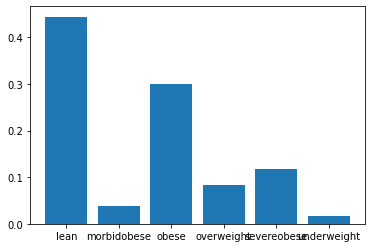

Distributions of cluster  2 :  [{'female': 0.6062176165803109, 'male': 0.39378238341968913}, {'CentralEurope': 0.772020725388601, 'Scandinavia': 0.10362694300518134, 'SouthEurope': 0.08290155440414508, 'UKIE': 0.03626943005181347, 'US': 0.0051813471502590676}, {'lean': 0.43523316062176165, 'morbidobese': 0.02072538860103627, 'obese': 0.26424870466321243, 'overweight': 0.15544041450777202, 'severeobese': 0.10880829015544041, 'underweight': 0.015544041450777202}]


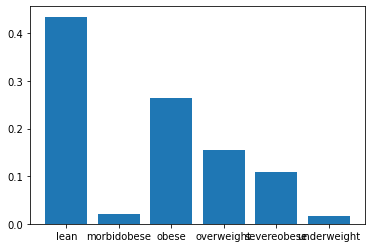

Distributions of cluster  3 :  [{'female': 0.5609756097560976, 'male': 0.43902439024390244}, {'CentralEurope': 0.5121951219512195, 'Scandinavia': 0.2926829268292683, 'SouthEurope': 0.036585365853658534, 'UKIE': 0.12195121951219512, 'US': 0.036585365853658534}, {'lean': 0.43902439024390244, 'morbidobese': 0.012195121951219513, 'obese': 0.2073170731707317, 'overweight': 0.2682926829268293, 'severeobese': 0.036585365853658534, 'underweight': 0.036585365853658534}]


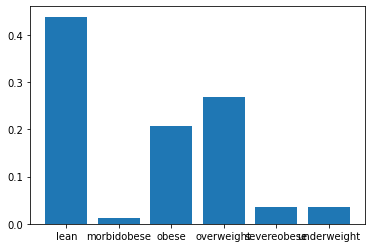

Distributions of cluster  4 :  [{'female': 0.6477272727272727, 'male': 0.3522727272727273}, {'CentralEurope': 0.3181818181818182, 'EasternEurope': 0.011363636363636364, 'Scandinavia': 0.45454545454545453, 'SouthEurope': 0.14772727272727273, 'UKIE': 0.011363636363636364, 'US': 0.056818181818181816}, {'lean': 0.5, 'obese': 0.18181818181818182, 'overweight': 0.20454545454545456, 'severeobese': 0.09090909090909091, 'underweight': 0.022727272727272728}]


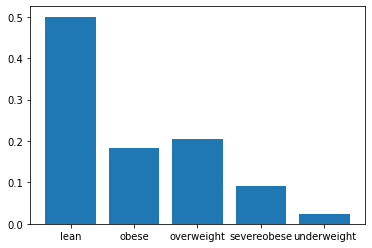

Distributions of cluster  5 :  [{'female': 0.7047619047619048, 'male': 0.29523809523809524}, {'CentralEurope': 0.8571428571428571, 'Scandinavia': 0.02857142857142857, 'SouthEurope': 0.0380952380952381, 'UKIE': 0.009523809523809525, 'US': 0.06666666666666667}, {'lean': 0.24761904761904763, 'morbidobese': 0.08571428571428572, 'obese': 0.3142857142857143, 'overweight': 0.12380952380952381, 'severeobese': 0.22857142857142856}]


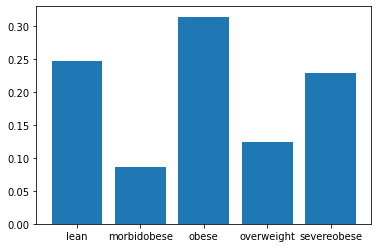

Distributions of cluster  6 :  [{'female': 0.7011494252873564, 'male': 0.2988505747126437}, {'CentralEurope': 0.4942528735632184, 'Scandinavia': 0.3103448275862069, 'SouthEurope': 0.10344827586206896, 'UKIE': 0.022988505747126436, 'US': 0.06896551724137931}, {'lean': 0.4827586206896552, 'morbidobese': 0.011494252873563218, 'obese': 0.14942528735632185, 'overweight': 0.26436781609195403, 'severeobese': 0.06896551724137931, 'underweight': 0.022988505747126436}]


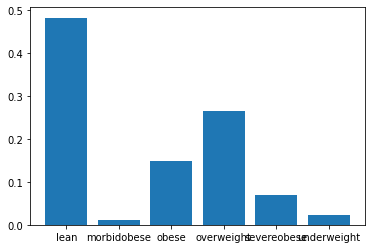

Distributions of cluster  7 :  [{'female': 0.6666666666666666, 'male': 0.3333333333333333}, {'CentralEurope': 0.5432098765432098, 'Scandinavia': 0.2222222222222222, 'SouthEurope': 0.13580246913580246, 'UKIE': 0.024691358024691357, 'US': 0.07407407407407407}, {'lean': 0.6172839506172839, 'obese': 0.1111111111111111, 'overweight': 0.19753086419753085, 'severeobese': 0.06172839506172839, 'underweight': 0.012345679012345678}]


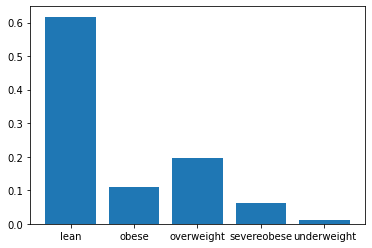

Distributions of cluster  8 :  [{'female': 0.6296296296296297, 'male': 0.37037037037037035}, {'CentralEurope': 0.43209876543209874, 'Scandinavia': 0.43209876543209874, 'SouthEurope': 0.07407407407407407, 'UKIE': 0.06172839506172839}, {'lean': 0.5061728395061729, 'obese': 0.13580246913580246, 'overweight': 0.2962962962962963, 'severeobese': 0.04938271604938271, 'underweight': 0.012345679012345678}]


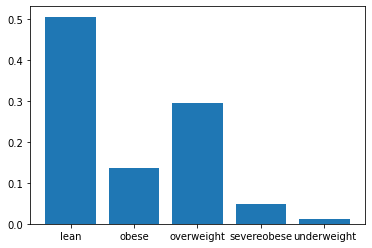

In [8]:
print("Distributions of all data: ", metadata_distributions(data_pd))

for i,l in enumerate(np.unique(dbscan_labels)):
    idx = np.where(dbscan_labels == l)[0]
    selection = data_pd.iloc[idx]
    print("Distributions of cluster ", i, ": ", metadata_distributions(selection))
    plt.bar(metadata_distributions(selection)[
            2].keys(), metadata_distributions(selection)[2].values())
    plt.show()



(1057, 2)


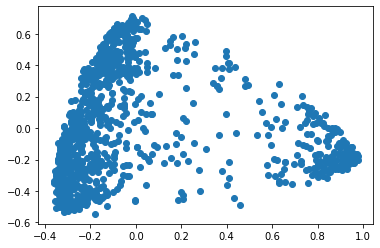

In [126]:
# now for bacteria
data = data.T

pca_model = PCA(n_components=2)
pca_model.fit(data)

projected_data = pca_model.transform(data)

print(projected_data.shape)


plt.scatter(projected_data[:, 0], projected_data[:, 1])
